In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/grape",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 12000 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

In [6]:
len(dataset) # one batch has 375 images so, 32 batches have 12000 in total

375

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 3 1 0 0 2 3 3 0 1 2 2 1 3 1 3 0 1 1 2 0 2 1 1 3 1 3 1 2 0 2 3]


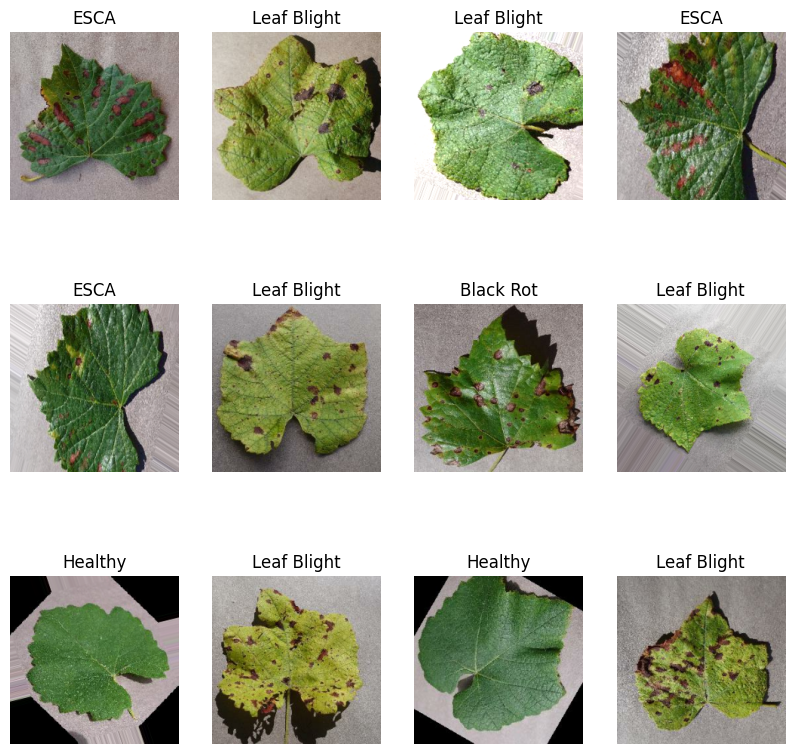

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

80 % --> Training
20 % --> 10 % Testing 10 % Validation

In [9]:
train_size = 0.8
test_size = 0.2
len(dataset)*train_size

300.0

In [10]:
train_dataset = dataset.take(300)
len(train_dataset)

300

In [11]:
test_dataset = dataset.skip(300)
len(test_dataset)

75

In [12]:
val_size = 0.1
len(dataset)*val_size

37.5

In [13]:
validation_dataset = test_dataset.take(37)
len(validation_dataset)

37

In [14]:
test_dataset = test_dataset.skip(37)
len(test_dataset)

38

In [15]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

300
37
38


In [16]:
# To automate the splitting procedure without hardcoding train-val-test sizes

def get_dataset_partitions(ds, train_split = 0.8, 
                           val_split = 0.1, 
                           test_split = 0.1, 
                           shuffle = True, 
                           shuffle_size = 10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions(dataset)

In [18]:
len(train_dataset)

300

In [19]:
len(val_dataset)

37

In [20]:
len(test_dataset)

38

In [21]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

C:\Users\jrsak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 222, 222, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 52, 52, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 24, 24, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 12, 12, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 10, 10, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 5, 5, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 3, 3, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 1, 1, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,524 (670.02 KB)

 Trainable params: 171,524 (670.02 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

history = model.fit(train_dataset,
         epochs = 25,
         batch_size = BATCH_SIZE,
         verbose = 1,
         validation_data = val_dataset)

Epoch 1/25


C:\Users\jrsak\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


300/300 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.5469 - loss: 0.9866 - val_accuracy: 0.7635 - val_loss: 0.5876
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.8247 - loss: 0.4344 - val_accuracy: 0.8218 - val_loss: 0.4634
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9174 - loss: 0.2252 - val_accuracy: 0.8649 - val_loss: 0.4057
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.9506 - loss: 0.1296 - val_accuracy: 0.9561 - val_loss: 0.1307
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.9578 - loss: 0.1273 - val_accuracy: 0.9696 - val_loss: 0.0884
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.9719 - loss: 0.0839 - val_accuracy: 0.9611 - val_loss: 0.1099
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.9781 - loss: 0.0664 - val_accuracy: 0.9139 - val_loss: 0.2834
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.9777 - loss: 0.0717 - val_accuracy: 0.982

In [27]:
scores = model.evaluate(test_dataset)

38/38 ━━━━━━━━━━━━━━━━━━━━ 211s 357ms/step - accuracy: 0.9905 - loss: 0.0296


In [28]:
scores

[0.04101454094052315, 0.9851973652839661]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 300}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


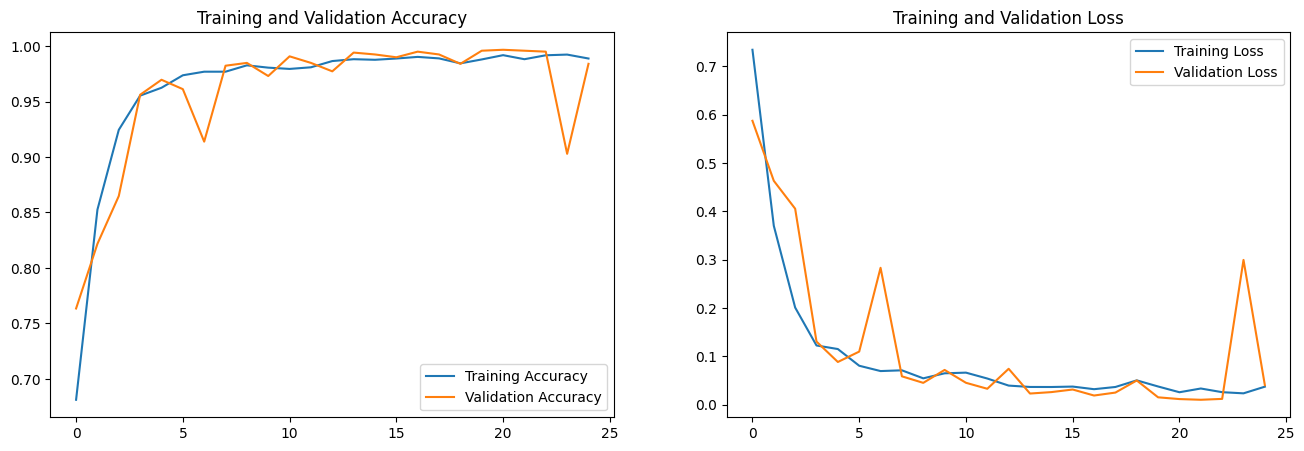

In [45]:
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
plt.plot(range(25), acc, label = 'Training Accuracy')
plt.plot(range(25), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(25), loss, label = 'Training Loss')
plt.plot(range(25), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First Image to Predict: 
Actual Disease: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Predicted Disease: Healthy


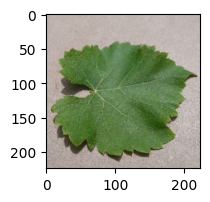

In [67]:
plt.figure(figsize=(2,2))
for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict: ")
    plt.imshow(first_image)
    print(f"Actual Disease: {class_names[first_label]}")
    batch_prediction = model.predict(images_batch)
    print(f"Predicted Disease: {class_names[batch_prediction[0].argmax()]}")

In [75]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[predictions[0].argmax()]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


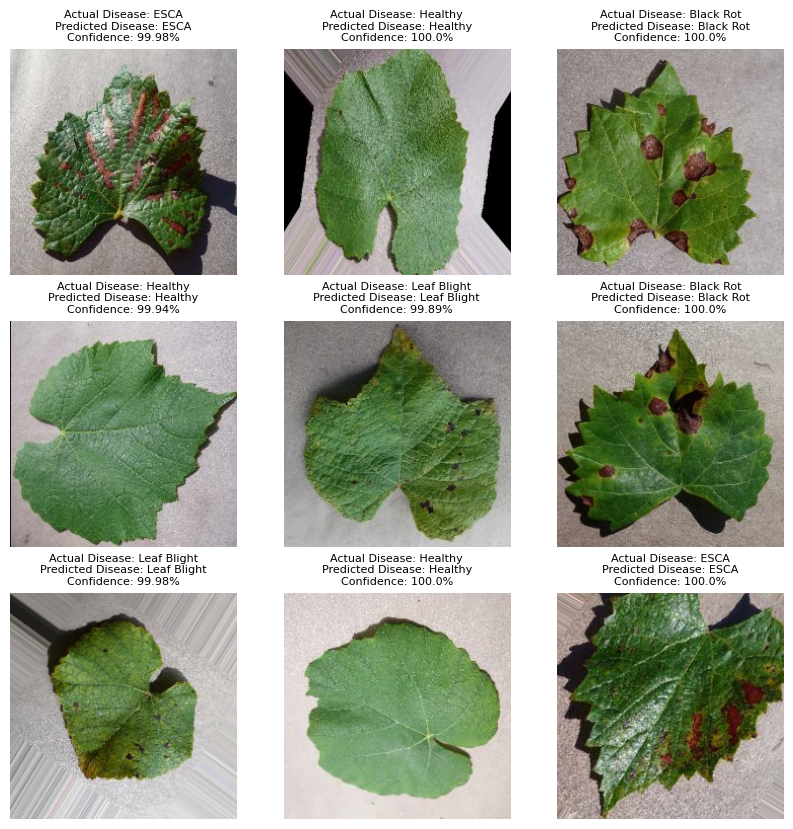

In [85]:
plt.figure(figsize = (10,10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual Disease: {actual_class}\nPredicted Disease: {predicted_class}\nConfidence: {confidence}%", fontsize=8)

In [94]:
model_version = 1

model.export(f'C:/Users/jrsak/OneDrive/Documents/Learning-ML/codebasics/Deep Learning/grape_disease/{model_version}')

INFO:tensorflow:Assets written to: C:/Users/jrsak/OneDrive/Documents/Learning-ML/codebasics/Deep Learning/grape_disease/1\assets


INFO:tensorflow:Assets written to: C:/Users/jrsak/OneDrive/Documents/Learning-ML/codebasics/Deep Learning/grape_disease/1\assets


Saved artifact at 'C:/Users/jrsak/OneDrive/Documents/Learning-ML/codebasics/Deep Learning/grape_disease/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2185702434672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702434848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702436256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702437488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702437136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702438016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702436432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702438896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702436784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2185702439248: TensorSpec(shape=